# Drug Rating Classifier

### Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

### Loading Datasets

In [2]:
df_train = pd.read_csv("train.tsv", sep = "\t")
df_dev = pd.read_csv("dev.tsv", sep = "\t")
df_test = pd.read_csv("test.tsv", sep = "\t")

In [3]:
print("The shape of train dataset is", df_train.shape)
df_train.head()

The shape of train dataset is (16000, 3)


,doc_id,review,rating
0,3518,"a horrible drug. macrobid should be banned, i ...",0
1,177888,took 30 mg/day for 2 months and no noticeable ...,0
2,219929,i have been taking this (10mg) for just over a...,1
3,131362,i've had terrible bumps and sores on my face f...,0
4,216596,the most frustrating experience of my life try...,0


In [4]:
print("The shape of dev dataset is", df_dev.shape)
df_dev.head()

The shape of dev dataset is (2000, 3)


,doc_id,review,rating
0,227093,i got my nexplanon in december 2013. two weeks...,1
1,219510,prescribed before and after cataract surgery w...,1
2,199407,i'm just finishing up my first month on the sh...,1
3,160884,took this medication for 4 months it didn't do...,0
4,33397,i think if you already had some underlying iss...,1


In [5]:
print("The shape of test dataset is", df_test.shape)
df_test.head()

The shape of test dataset is (2000, 3)


,doc_id,review,rating
0,37451,we switched on the advice of the then new adhd...,-10
1,193385,"helps me sleep, but i don't notice much relaxi...",-10
2,216485,"sometimes use it. really good effect, my wife ...",-10
3,84065,i first started this birth control two years a...,-10
4,146801,i was prescribed these for an onset of panic a...,-10


Here we need to predict rating of test data and incorporate into it.

#### Features and target seperation

In [6]:
X_train = df_train['review']
y_train = df_train['rating']
X_dev = df_dev['review']
y_dev = df_dev['rating']
X_test = df_test['review']
y_test = df_test['rating']

### Exploratory Data Analysis

1    8151
0    7849
Name: rating, dtype: int64

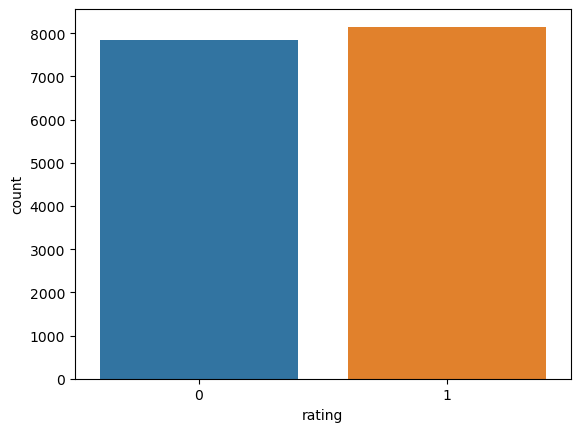

In [7]:
import seaborn as sn
sn.countplot(x="rating",data = df_train)
df_train["rating"].value_counts()

0    1007
1     993
Name: rating, dtype: int64

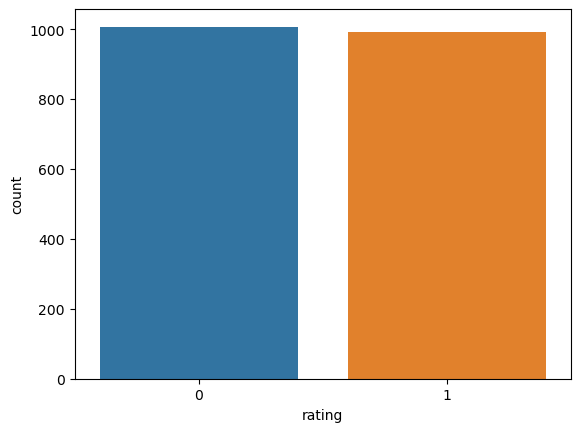

In [8]:
sn.countplot(x="rating",data = df_dev)
df_dev["rating"].value_counts()

### Data Preprocessing

#### Tokenizing the text data

In [9]:
max_words = 1000
max_seq_length = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_dev_seq = tokenizer.texts_to_sequences(X_dev)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_dev_pad = pad_sequences(X_dev_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

### Building Model

In [10]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### early stopping

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
epochs = 10
batch_size = 32
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_dev_pad, y_dev), callbacks=[early_stop])

Epoch 1/10
500/500 [==============================] - 20s 36ms/step - loss: 0.5061 - accuracy: 0.7479 - val_loss: 0.4396 - val_accuracy: 0.7990
Epoch 2/10
500/500 [==============================] - 18s 36ms/step - loss: 0.4078 - accuracy: 0.8201 - val_loss: 0.4343 - val_accuracy: 0.7915
Epoch 3/10
500/500 [==============================] - 17s 34ms/step - loss: 0.3762 - accuracy: 0.8381 - val_loss: 0.4414 - val_accuracy: 0.7950
Epoch 4/10
500/500 [==============================] - 17s 35ms/step - loss: 0.3540 - accuracy: 0.8485 - val_loss: 0.4165 - val_accuracy: 0.8115
Epoch 5/10
500/500 [==============================] - 18s 36ms/step - loss: 0.3381 - accuracy: 0.8591 - val_loss: 0.4327 - val_accuracy: 0.8050
Epoch 6/10
500/500 [==============================] - 18s 36ms/step - loss: 0.3145 - accuracy: 0.8712 - val_loss: 0.4438 - val_accuracy: 0.8040
Epoch 7/10
500/500 [==============================] - 18s 36ms/step - loss: 0.2892 - accuracy: 0.8836 - val_loss: 0.4441 - val_accuracy:

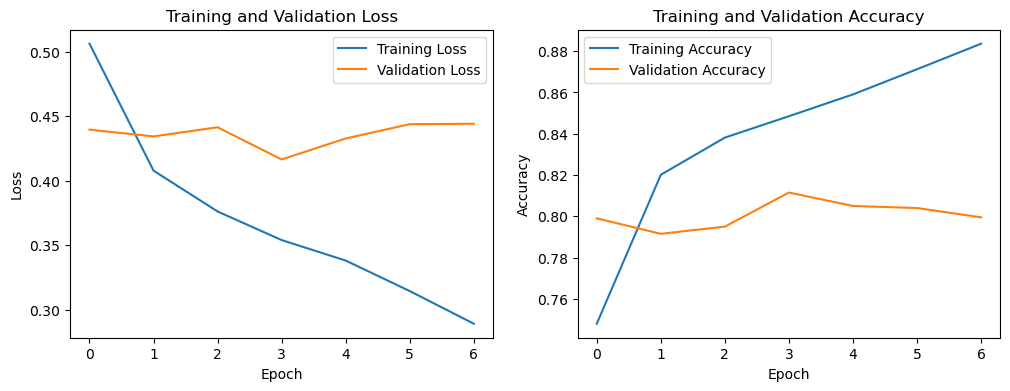

In [14]:
# Plot training history (loss and accuracy)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

### Model Evaluation

#### Train Data

In [15]:
# Evaluate the model
score = model.evaluate(X_train_pad, y_train, verbose=0)
print("Train Accuracy:", score[1])

Train Accuracy: 0.8784375190734863


500/500 [==============================] - 7s 13ms/step


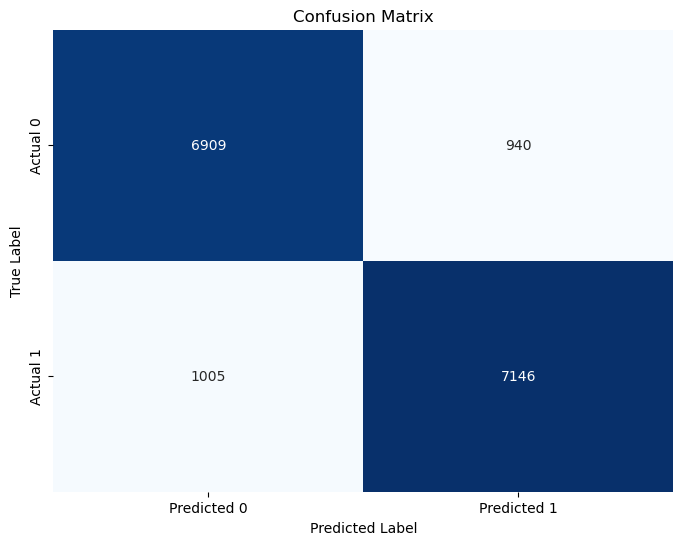


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7849
           1       0.88      0.88      0.88      8151

    accuracy                           0.88     16000
   macro avg       0.88      0.88      0.88     16000
weighted avg       0.88      0.88      0.88     16000



In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for train data
train_predictions = model.predict(X_train_pad)
train_labels = [1 if pred > 0.5 else 0 for pred in train_predictions]

# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, train_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_train, train_labels)
print("\nClassification Report:")
print(class_report)


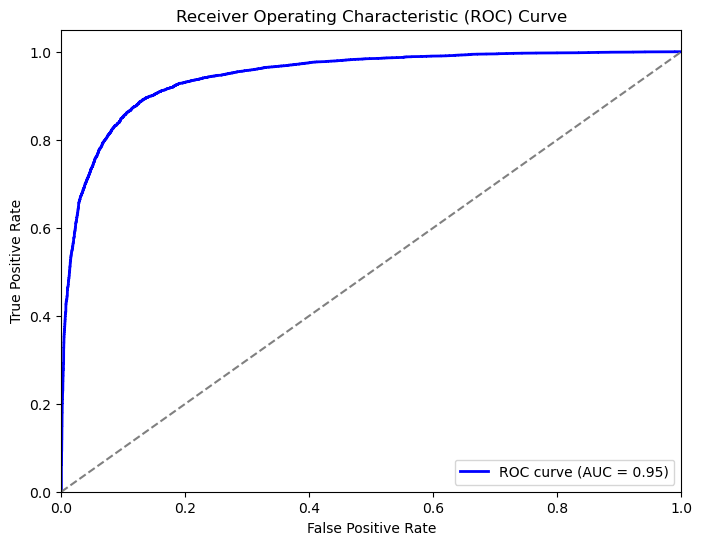

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, train_predictions)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_train, train_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


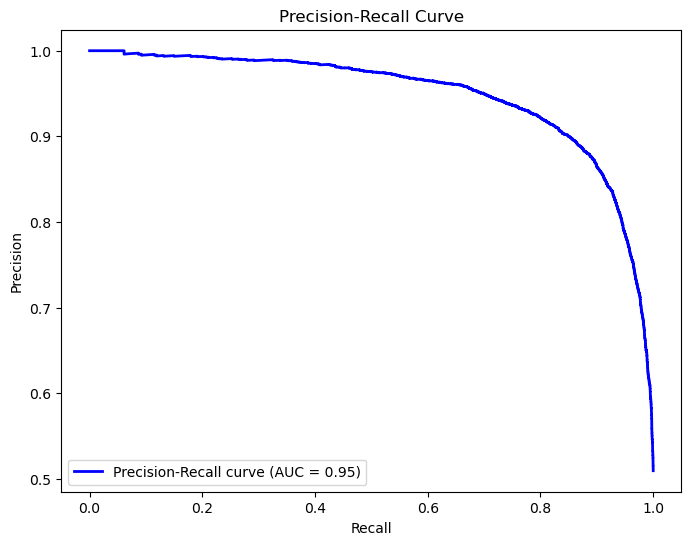

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_train, train_predictions)

# Compute Area Under the Curve (AUC) for Precision-Recall curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


#### Dev data

In [19]:
# Evaluate the model
score = model.evaluate(X_dev_pad, y_dev, verbose=0)
print("Dev Accuracy:", score[1])

Dev Accuracy: 0.8115000128746033


63/63 [==============================] - 1s 13ms/step


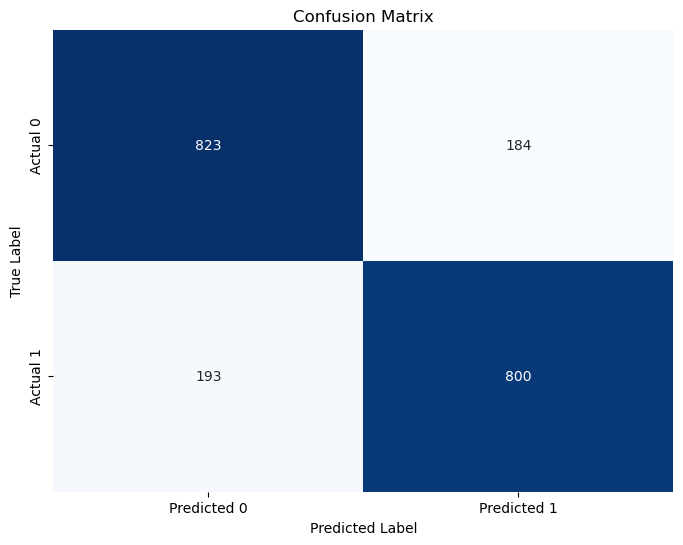


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1007
           1       0.81      0.81      0.81       993

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for dev data
dev_predictions = model.predict(X_dev_pad)
dev_labels = [1 if pred > 0.5 else 0 for pred in dev_predictions]

# Generate confusion matrix
conf_matrix = confusion_matrix(y_dev, dev_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_dev, dev_labels)
print("\nClassification Report:")
print(class_report)

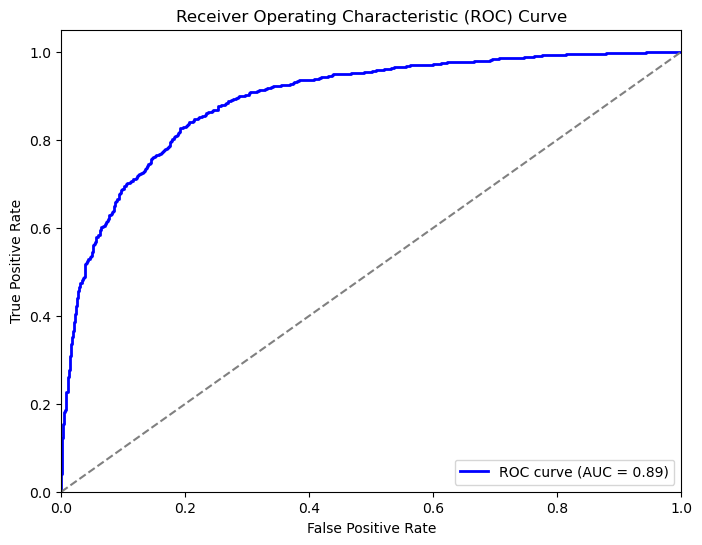

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_dev, dev_predictions)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_dev, dev_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

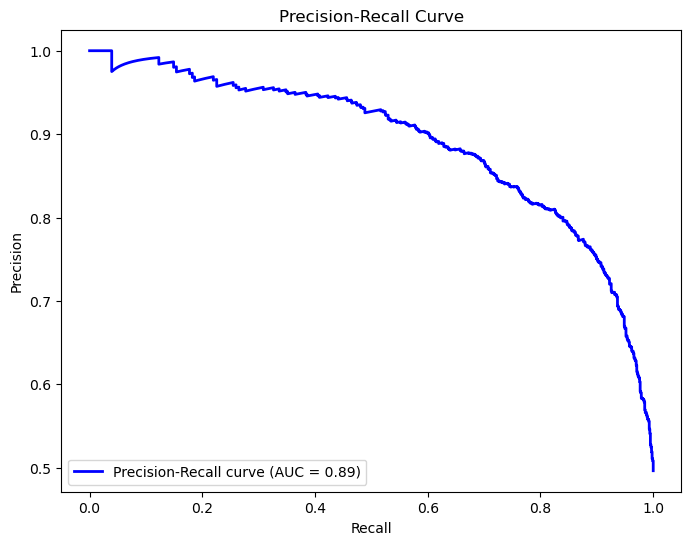

In [22]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_dev, dev_predictions)

# Compute Area Under the Curve (AUC) for Precision-Recall curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [24]:
# Predict labels for test data
test_predictions = model.predict(X_test_pad)
# Convert probabilities to binary labels
test_labels = [1 if pred > 0.5 else 0 for pred in test_predictions]
# Replace -10 values with predicted labels
df_test['rating'] = test_labels
# Write the updated test data to a new TSV file
df_test.to_csv("test_predictions.tsv", sep = "\t", index=False)

63/63 [==============================] - 1s 12ms/step
